<a href="https://colab.research.google.com/github/twelvesense/first-repository/blob/master/ExplNode17.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**프로젝트: Movielens 영화 SBR**

#1: 기본 환경 구축

##1.1: 모듈

In [1]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Dropout, GRU
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tqdm import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime as dt
from pathlib import Path
import os
import warnings
warnings.filterwarnings('ignore')

In [ ]:
# short_session을 제거한 다음 unpopular item을 제거하고, 
# 다시 길이가 1인 session이 생길 수 있어, 반복문을 통해 지속적으로 제거

def cleanse_recursive(data: pd.DataFrame, shortest, least_click) -> pd.DataFrame:
    while True:
        before_len = len(data)
        data = cleanse_short_session(data, shortest)
        data = cleanse_unpopular_item(data, least_click)
        after_len = len(data)
        if before_len == after_len:
            break
    return data

def cleanse_short_session(data: pd.DataFrame, shortest):
    session_len = data.groupby('UserId').size()
    session_use = session_len[session_len >= shortest].index
    data = data[data['UserId'].isin(session_use)]
    return data

def cleanse_unpopular_item(data: pd.DataFrame, least_click):
    item_popular = data.groupby('ItemId').size()
    item_use = item_popular[item_popular >= least_click].index
    data = data[data['ItemId'].isin(item_use)]
    return data

In [ ]:
def split_by_date(data: pd.DataFrame, n_days: int):
    final_time = data['Time'].max()
    session_last_time = data.groupby('Time')['Time'].max()
    session_in_train = session_last_time[session_last_time < final_time - dt.timedelta(n_days)].index
    session_in_test = session_last_time[session_last_time >= final_time - dt.timedelta(n_days)].index

    before_date = data[data['Time'].isin(session_in_train)]
    after_date = data[data['Time'].isin(session_in_test)]
    # after_date = after_date[after_date['ItemId'].isin(before_date['ItemId'])]
    return before_date, after_date

In [ ]:
# data에 대한 정보를 살펴보기
def stats_info(data: pd.DataFrame, status: str):
    print(f'* {status} Set Stats Info\n'
          f'\t Events: {len(data)}\n'
          f'\t Sessions: {data["UserId"].nunique()}\n'
          f'\t Items: {data["ItemId"].nunique()}\n'
          f'\t First Time : {data["Time"].min()}\n'
          f'\t Last Time : {data["Time"].max()}\n')

In [ ]:
# SessionDataset
class SessionDataset:
    """Credit to yhs-968/pyGRU4REC."""

    def __init__(self, data):
        self.df = data
        self.click_offsets = self.get_click_offsets()
        self.session_idx = np.arange(self.df['UserId'].nunique())  # indexing to UserId

    def get_click_offsets(self):
        """
        Return the indexes of the first click of each session IDs,
        """
        offsets = np.zeros(self.df['UserId'].nunique() + 1, dtype=np.int32)
        offsets[1:] = self.df.groupby('UserId').size().cumsum()
        return offsets

In [ ]:
# SessionDataLoader
class SessionDataLoader:
    def __init__(self, dataset: SessionDataset, batch_size=50):
        self.dataset = dataset
        self.batch_size = batch_size

    def __iter__(self):
        start, end, mask, last_session, finished = self.initialize()  # initialize 메소드에서 확인
        while not finished:
            min_len = (end - start).min() - 1  # Shortest Length Among Sessions
            for i in range(min_len):
                # Build inputs & targets
                inp = self.dataset.df['item_idx'].values[start + i]
                target = self.dataset.df['item_idx'].values[start + i + 1]
                yield inp, target, mask

            start, end, mask, last_session, finished = self.update_status(start, end, min_len, last_session, finished)

    def initialize(self):
        first_iters = np.arange(self.batch_size)    # 첫 배치에 사용할 세션 Index를 가져옵니다.
        last_session = self.batch_size - 1    # 마지막으로 다루고 있는 세션 Index를 저장해둡니다.
        start = self.dataset.click_offsets[self.dataset.session_idx[first_iters]]       # data 상에서 session이 시작된 위치를 가져옵니다.
        end = self.dataset.click_offsets[self.dataset.session_idx[first_iters] + 1]  # session이 끝난 위치 바로 다음 위치를 가져옵니다.
        mask = np.array([])   # session의 모든 아이템을 다 돌은 경우 mask에 추가해줄 것입니다.
        finished = False         # data를 전부 돌았는지 기록하기 위한 변수입니다.
        return start, end, mask, last_session, finished

    def update_status(self, start: np.ndarray, end: np.ndarray, min_len: int, last_session: int, finished: bool):  
        # 다음 배치 데이터를 생성하기 위해 상태를 update합니다.
        
        start += min_len   # __iter__에서 min_len 만큼 for문을 돌았으므로 start를 min_len 만큼 더해줍니다.
        mask = np.arange(self.batch_size)[(end - start) == 1]  
        # end는 다음 세션이 시작되는 위치인데 start와 한 칸 차이난다는 것은 session이 끝났다는 뜻입니다. mask에 기록해줍니다.

        for i, idx in enumerate(mask, start=1):  # mask에 추가된 세션 개수만큼 새로운 세션을 돌것입니다.
            new_session = last_session + i  
            if new_session > self.dataset.session_idx[-1]:  # 만약 새로운 세션이 마지막 세션 index보다 크다면 모든 학습데이터를 돈 것입니다.
                finished = True
                break
            # update the next starting/ending point
            start[idx] = self.dataset.click_offsets[self.dataset.session_idx[new_session]]     # 종료된 세션 대신 새로운 세션의 시작점을 기록합니다.
            end[idx] = self.dataset.click_offsets[self.dataset.session_idx[new_session] + 1]

        last_session += len(mask)  # 마지막 세션의 위치를 기록해둡니다.
        return start, end, mask, last_session, finished

In [89]:
# train 셋으로 학습하면서 valid 셋으로 검증
from matplotlib.pylab import rcParams

def train_model(model, args):
    train_dataset = SessionDataset(args.tr)
    train_loader = SessionDataLoader(train_dataset, batch_size=args.batch_size)
     
    history = {'train_loss':[], 'accuracy':[], 'val_recall':[], 'val_mrr':[]}

    for epoch in range(1, args.epochs + 1):

        total_step = len(args.tr) - args.tr['UserId'].nunique()
        tr_loader = tqdm(train_loader, total=total_step // args.batch_size, desc='Train', mininterval=1)
        for feat, target, mask in tr_loader:
            reset_hidden_states(model, mask)  # 종료된 session은 hidden_state를 초기화합니다. 아래 메서드에서 확인해주세요.

            input_ohe = to_categorical(feat, num_classes=args.num_items)
            input_ohe = np.expand_dims(input_ohe, axis=1)
            target_ohe = to_categorical(target, num_classes=args.num_items)

            result = model.train_on_batch(input_ohe, target_ohe)
            tr_loader.set_postfix(train_loss=result[0], accuracy = result[1])
        


        val_recall, val_mrr = get_metrics(args.val, model, args, args.k)  # valid set에 대해 검증합니다.

        print(f"\t - Recall@{args.k} epoch {epoch}: {val_recall:3f}")
        print(f"\t - MRR@{args.k}    epoch {epoch}: {val_mrr:3f}\n")

        history['val_recall'].append(val_recall)
        history['val_mrr'].append(val_mrr)

    rcParams['figure.figsize'] = 15, 6
    plt.subplot(1,2,1)
    plt.plot(history['val_recall'])  
    plt.title('val_recall')  
    plt.xlabel('epochs')  

    plt.subplot(1,2,2)  
    plt.plot(history['val_mrr'])  
    plt.title('val_mrr')  
    plt.xlabel('epochs')  

def reset_hidden_states(model, mask):
    gru_layer = model.get_layer(name='GRU')  # model에서 gru layer를 가져옵니다.
    hidden_states = gru_layer.states[0].numpy()  # gru_layer의 parameter를 가져옵니다.
    for elt in mask:  # mask된 인덱스 즉, 종료된 세션의 인덱스를 돌면서
        hidden_states[elt, :] = 0  # parameter를 초기화 합니다.
    gru_layer.reset_states(states=hidden_states)

def get_metrics(data, model, args, k: int):  # valid셋과 test셋을 평가하는 코드입니다. 
                                             # train과 거의 같지만 mrr, recall을 구하는 라인이 있습니다.
    dataset = SessionDataset(data)
    loader = SessionDataLoader(dataset, batch_size=args.batch_size)
    recall_list, mrr_list = [], []

    total_step = len(data) - data['UserId'].nunique()
    for inputs, label, mask in tqdm(loader, total=total_step // args.batch_size, desc='Evaluation', mininterval=1):
        reset_hidden_states(model, mask)
        input_ohe = to_categorical(inputs, num_classes=args.num_items)
        input_ohe = np.expand_dims(input_ohe, axis=1)

        pred = model.predict(input_ohe, batch_size=args.batch_size)
        pred_arg = tf.argsort(pred, direction='DESCENDING')  # softmax 값이 큰 순서대로 sorting 합니다.

        length = len(inputs)
        recall_list.extend([recall_k(pred_arg[i], label[i], k) for i in range(length)])
        mrr_list.extend([mrr_k(pred_arg[i], label[i], k) for i in range(length)])

    recall, mrr = np.mean(recall_list), np.mean(mrr_list)
    return recall, mrr

In [58]:
def test_model(model, args, test):
    test_recall, test_mrr = get_metrics(test, model, args, 20)
    print(f"\t - Recall@{args.k}: {test_recall:3f}")
    print(f"\t - MRR@{args.k}: {test_mrr:3f}\n")

##1.2: 데이터

In [2]:
# 디렉토리
from google.colab import drive
drive.mount('/content/drive')
colab_dir = '/content/drive/MyDrive/colab/ExplNode17'

Mounted at /content/drive


In [20]:
data_path = Path(colab_dir + '/data/') 
train_path = data_path / 'ratings.dat'

def load_data(data_path: Path, nrows=None):
    data = pd.read_csv(data_path, sep='::', header=None, usecols=[0, 1, 2, 3], dtype={0: np.int32, 1: np.int32, 2: np.int32}, nrows=nrows)
    data.columns = ['UserId', 'ItemId', 'Rating', 'Time']
    return data

data = load_data(train_path, None)
data.sort_values(['UserId', 'Time'], inplace=True)  # data를 id와 시간 순서로 정렬

In [21]:
data

,UserId,ItemId,Rating,Time
31,1,3186,4,978300019
22,1,1270,5,978300055
27,1,1721,4,978300055
37,1,1022,5,978300055
24,1,2340,3,978300103
...,...,...,...,...
1000019,6040,2917,4,997454429
999988,6040,1921,4,997454464
1000172,6040,1784,3,997454464
1000167,6040,161,3,997454486


# 2: 데이터의 전처리

##2.1: 유저 수(세션 수)와 아이템 수

In [22]:
# 유저 수(세션 수)와 아이템 수 확인
data['UserId'].nunique(), data['ItemId'].nunique()

(6040, 3706)

## 2.2: Session Length

In [23]:
# UserId를 SessionId로 해석하고, 각 세션별 클릭 데이터를 분석
session_length = data.groupby('UserId').size()
session_length

UserId
1        53
2       129
3        51
4        21
5       198
       ... 
6036    888
6037    202
6038     20
6039    123
6040    341
Length: 6040, dtype: int64

In [24]:
# session length의 median값 session length으ㅢ .mean값
session_length.median(), session_length.mean()

(96.0, 165.5975165562914)

In [25]:
# session length의 min값, session length의 max값
session_length.min(), session_length.max()

(20, 2314)

In [26]:
# session length의 quantile(0.999): 분위수(99.9%)
session_length.quantile(0.999)

1343.181000000005

In [27]:
# 길이가 100인 세션은 뭔가 이상할 수 있어, 그 중 하나를 파악
long_session = session_length[session_length==100].index[0]
data[data['UserId']==long_session]

,UserId,ItemId,Rating,Time
5428,38,587,4,978044341
5479,38,3072,4,978044383
5467,38,356,4,978044437
5516,38,490,2,978044437
5498,38,531,3,978044473
...,...,...,...,...
5452,38,13,3,978046407
5490,38,455,3,978046465
5464,38,1380,4,978046582
5433,38,3948,4,978046603


In [28]:
# 세션 길이 기준 하위 99.9%까지의 분포 누적합을 시각화한 것
length_count = session_length.groupby(session_length).size()
length_percent_cumsum = length_count.cumsum() / length_count.sum()
length_percent_cumsum_999 = length_percent_cumsum[length_percent_cumsum < 0.999]

length_percent_cumsum_999

20      0.014238
21      0.029305
22      0.042053
23      0.055464
24      0.068874
          ...   
1271    0.998179
1277    0.998344
1286    0.998510
1302    0.998675
1323    0.998841
Length: 736, dtype: float64

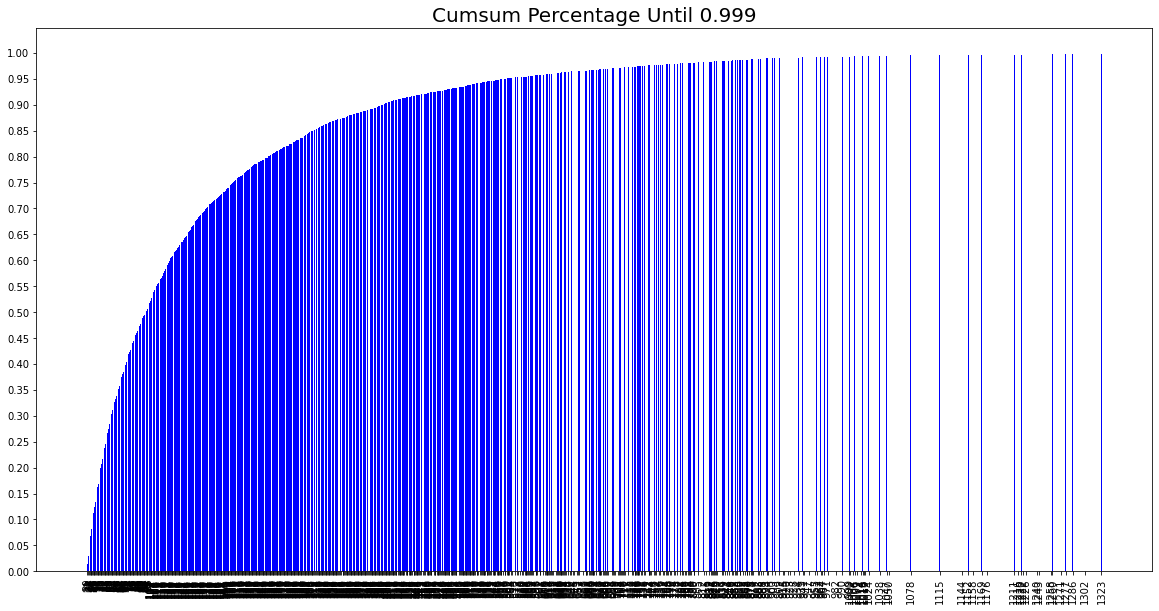

In [13]:
plt.figure(figsize=(20, 10))
plt.bar(x=length_percent_cumsum_999.index,
        height=length_percent_cumsum_999, color='blue')
plt.xticks(length_percent_cumsum_999.index, fontsize=10, rotation = 90)
plt.yticks(np.arange(0, 1.01, 0.05))
plt.title('Cumsum Percentage Until 0.999', size=20)
plt.show()

##2.3: Session Time

In [29]:
# time의 표현 방식 변경하기
data['Time'] = data['Time'].apply(dt.datetime.fromtimestamp)

In [30]:
# 데이터의 시간 관련 정보 파악
oldest, latest = data['Time'].min(), data['Time'].max()
print(oldest)
print(latest)

2000-04-25 23:05:32
2003-02-28 17:49:50


## 2.4: Data Cleansing

In [34]:
data1 = data1.sort_values('Time')

In [35]:
# data cleansing; Each user has at least 20 ratings
data1 = cleanse_recursive(data1, shortest=4, least_click=20)
data1

,UserId,ItemId,Rating,Time
1000138,6040,858,4,2000-04-25 23:05:32
999873,6040,593,5,2000-04-25 23:05:54
1000153,6040,2384,4,2000-04-25 23:05:54
1000007,6040,1961,4,2000-04-25 23:06:17
1000192,6040,2019,5,2000-04-25 23:06:17
...,...,...,...,...
825497,4958,2453,4,2003-02-28 17:44:20
825526,4958,3489,4,2003-02-28 17:45:20
825438,4958,1407,5,2003-02-28 17:47:23
825724,4958,3264,4,2003-02-28 17:49:08


## 2.5: Train / Valid / Test split

In [37]:
# 가장 마지막 1일 기간 동안을 Test로, 2일 전부터 1일 전 까지를 valid set으로 나눔

tr, test = split_by_date(data, n_days=100)
tr, val = split_by_date(tr, n_days=200)

In [39]:
# tr, val, test에 대한 정보를 살펴보기
stats_info(tr, 'train')
stats_info(val, 'valid')
stats_info(test, 'test')

* train Set Stats Info
	 Events: 979094
	 Sessions: 6038
	 Items: 3700
	 First Time : 2000-04-25 23:05:32
	 Last Time : 2002-03-05 04:19:56

* valid Set Stats Info
	 Events: 12292
	 Sessions: 399
	 Items: 2627
	 First Time : 2002-03-05 04:21:07
	 Last Time : 2002-09-01 04:20:59

* test Set Stats Info
	 Events: 8823
	 Sessions: 339
	 Items: 2333
	 First Time : 2002-09-01 19:41:39
	 Last Time : 2003-02-28 17:49:50



In [40]:
# train set에 없는 아이템이 val, test기간에 생길 수 있으므로 train data를 기준으로 인덱싱
id2idx = {item_id : index for index, item_id in enumerate(tr['ItemId'].unique())}

def indexing(df, id2idx):
    df['item_idx'] = df['ItemId'].map(lambda x: id2idx.get(x, -1))  # id2idx에 없는 아이템은 모르는 값(-1) 처리 해줌
    return df

tr = indexing(tr, id2idx)
val = indexing(val, id2idx)
test = indexing(test, id2idx)

In [41]:
# 데이터를 저장
save_path = data_path / 'processed'
save_path.mkdir(parents=True, exist_ok=True)

tr.to_pickle(save_path / 'train.pkl')
val.to_pickle(save_path / 'valid.pkl')
test.to_pickle(save_path / 'test.pkl')

# 3: 미니 배치의 구성

## 3.1: SessionDataset

In [43]:
# train데이터로 SessionDataset 객체를 만들고 인스턴스 변수들을 살펴보기
tr_dataset = SessionDataset(tr)
tr_dataset.df.head(10)

,UserId,ItemId,Rating,Time,item_idx
31,1,3186,4,2000-12-31 22:00:19,0
22,1,1270,5,2000-12-31 22:00:55,1
27,1,1721,4,2000-12-31 22:00:55,2
37,1,1022,5,2000-12-31 22:00:55,3
24,1,2340,3,2000-12-31 22:01:43,4
36,1,1836,5,2000-12-31 22:02:52,5
3,1,3408,4,2000-12-31 22:04:35,6
7,1,2804,5,2000-12-31 22:11:59,7
47,1,1207,4,2000-12-31 22:11:59,8
0,1,1193,5,2000-12-31 22:12:40,9


In [44]:
# tr_dataset.click_offsets
tr_dataset.click_offsets

array([     0,     53,    182, ..., 978630, 978753, 979094], dtype=int32)

In [45]:
# tr_dataset.session_idx
tr_dataset.session_idx

array([   0,    1,    2, ..., 6035, 6036, 6037])

## 3.2: SessionDataLoader

In [47]:
# SessionDataLoader 데이터 확인
tr_data_loader = SessionDataLoader(tr_dataset, batch_size=4)
tr_dataset.df.head(15)

,UserId,ItemId,Rating,Time,item_idx
31,1,3186,4,2000-12-31 22:00:19,0
22,1,1270,5,2000-12-31 22:00:55,1
27,1,1721,4,2000-12-31 22:00:55,2
37,1,1022,5,2000-12-31 22:00:55,3
24,1,2340,3,2000-12-31 22:01:43,4
36,1,1836,5,2000-12-31 22:02:52,5
3,1,3408,4,2000-12-31 22:04:35,6
7,1,2804,5,2000-12-31 22:11:59,7
47,1,1207,4,2000-12-31 22:11:59,8
0,1,1193,5,2000-12-31 22:12:40,9


In [48]:
iter_ex = iter(tr_data_loader)

In [49]:
# input, output, mask 확인
inputs, labels, mask =  next(iter_ex)
print(f'Model Input Item Idx are : {inputs}')
print(f'Label Item Idx are : {"":5} {labels}')
print(f'Previous Masked Input Idx are {mask}')

Model Input Item Idx are : [ 0 53 65 54]
Label Item Idx are :       [ 1 54 62 24]
Previous Masked Input Idx are []


# 4: 모델 구성

## 4.1: Evaluation Metric

In [50]:
def mrr_k(pred, truth: int, k: int):
    indexing = np.where(pred[:k] == truth)[0]
    if len(indexing) > 0:
        return 1 / (indexing[0] + 1)
    else:
        return 0

def recall_k(pred, truth: int, k: int) -> int:
    answer = truth in pred[:k]
    return int(answer)

## 4.2: Model Architecture

In [51]:
# model 생성
def create_model(args):
    inputs = Input(batch_shape=(args.batch_size, 1, args.num_items))
    gru, _ = GRU(args.hsz, stateful=True, return_state=True, name='GRU')(inputs)
    dropout = Dropout(args.drop_rate)(gru)
    predictions = Dense(args.num_items, activation='softmax')(dropout)
    model = Model(inputs=inputs, outputs=[predictions])
    model.compile(loss=categorical_crossentropy, optimizer=Adam(args.lr), metrics=['accuracy'])
    model.summary()
    return model

In [52]:
# hyper-parameter
class Args:
    def __init__(self, tr, val, test, batch_size, hsz, drop_rate, lr, epochs, k):
        self.tr = tr
        self.val = val
        self.test = test
        self.num_items = tr['ItemId'].nunique()
        self.num_sessions = tr['UserId'].nunique()
        self.batch_size = batch_size
        self.hsz = hsz
        self.drop_rate = drop_rate
        self.lr = lr
        self.epochs = epochs
        self.k = k

In [63]:
args = Args(tr, val, test, batch_size=256, hsz=50, drop_rate=0.1, lr=0.001, epochs=5, k=20)

In [64]:
# model 생성
model = create_model(args)

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(256, 1, 3700)]          0         
                                                                 
 GRU (GRU)                   [(256, 50),               562800    
                              (256, 50)]                         
                                                                 
 dropout_2 (Dropout)         (256, 50)                 0         
                                                                 
 dense_2 (Dense)             (256, 3700)               188700    
                                                                 
Total params: 751,500
Trainable params: 751,500
Non-trainable params: 0
_________________________________________________________________


# 5: 모델 학습 및 테스트

###5.1: 기본 하이퍼파라미터

In [91]:
args = Args(tr, val, test, batch_size=256, hsz=50, drop_rate=0.1, lr=0.001, epochs=5, k=20)

Evaluation:  15%|█▌        | 7/46 [00:12<01:09,  1.79s/it]


	 - Recall@20 epoch 1: 0.114955
	 - MRR@20    epoch 1: 0.038284



Evaluation:  15%|█▌        | 7/46 [00:12<01:09,  1.78s/it]


	 - Recall@20 epoch 2: 0.113839
	 - MRR@20    epoch 2: 0.037582



Evaluation:  15%|█▌        | 7/46 [00:12<01:09,  1.79s/it]


	 - Recall@20 epoch 3: 0.111049
	 - MRR@20    epoch 3: 0.037808



Evaluation:  15%|█▌        | 7/46 [00:12<01:09,  1.78s/it]


	 - Recall@20 epoch 4: 0.113281
	 - MRR@20    epoch 4: 0.037928



Evaluation:  15%|█▌        | 7/46 [00:12<01:09,  1.78s/it]


	 - Recall@20 epoch 5: 0.112165
	 - MRR@20    epoch 5: 0.036980



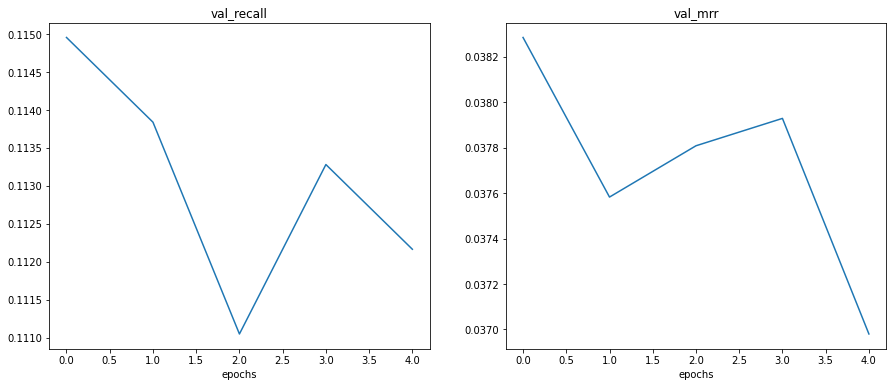

In [92]:
# 학습
train_model(model, args)

In [93]:
# 평가
test_model(model, args, test)

Evaluation:   6%|▌         | 2/33 [00:03<00:56,  1.83s/it]

	 - Recall@20: 0.113281
	 - MRR@20: 0.038930



##5.2: hsz 변경 (50 -> 100)

In [94]:
args = Args(tr, val, test, batch_size=256, hsz=100, drop_rate=0.1, lr=0.001, epochs=5, k=20)

Evaluation:  15%|█▌        | 7/46 [00:12<01:10,  1.81s/it]


	 - Recall@20 epoch 1: 0.114397
	 - MRR@20    epoch 1: 0.036905



Evaluation:  15%|█▌        | 7/46 [00:12<01:08,  1.77s/it]


	 - Recall@20 epoch 2: 0.113839
	 - MRR@20    epoch 2: 0.036536



Evaluation:  15%|█▌        | 7/46 [00:12<01:09,  1.78s/it]


	 - Recall@20 epoch 3: 0.116071
	 - MRR@20    epoch 3: 0.037638



Evaluation:  15%|█▌        | 7/46 [00:12<01:09,  1.79s/it]


	 - Recall@20 epoch 4: 0.116071
	 - MRR@20    epoch 4: 0.037159



Evaluation:  15%|█▌        | 7/46 [00:12<01:09,  1.77s/it]


	 - Recall@20 epoch 5: 0.114397
	 - MRR@20    epoch 5: 0.036208



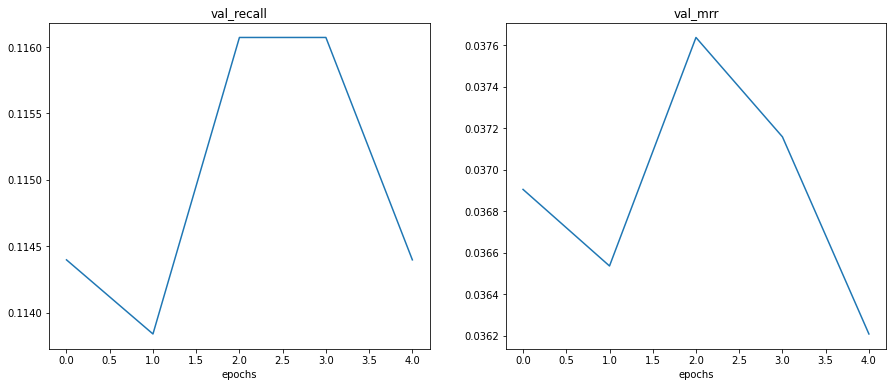

In [95]:
# 학습
train_model(model, args)

In [96]:
# 평가
test_model(model, args, test)

Evaluation:   6%|▌         | 2/33 [00:03<00:59,  1.93s/it]

	 - Recall@20: 0.117188
	 - MRR@20: 0.036051



##5.3:  drop_rate 변경 (0.1 -> 0.2)

In [97]:
args = Args(tr, val, test, batch_size=256, hsz=50, drop_rate=0.2, lr=0.001, epochs=5, k=20)

Evaluation:  15%|█▌        | 7/46 [00:12<01:09,  1.77s/it]


	 - Recall@20 epoch 1: 0.114397
	 - MRR@20    epoch 1: 0.036198



Evaluation:  15%|█▌        | 7/46 [00:12<01:08,  1.77s/it]


	 - Recall@20 epoch 2: 0.113281
	 - MRR@20    epoch 2: 0.035832



Evaluation:  15%|█▌        | 7/46 [00:12<01:09,  1.78s/it]


	 - Recall@20 epoch 3: 0.113281
	 - MRR@20    epoch 3: 0.035869



Evaluation:  15%|█▌        | 7/46 [00:12<01:09,  1.79s/it]


	 - Recall@20 epoch 4: 0.113839
	 - MRR@20    epoch 4: 0.036597



Evaluation:  15%|█▌        | 7/46 [00:12<01:09,  1.79s/it]


	 - Recall@20 epoch 5: 0.112723
	 - MRR@20    epoch 5: 0.036712



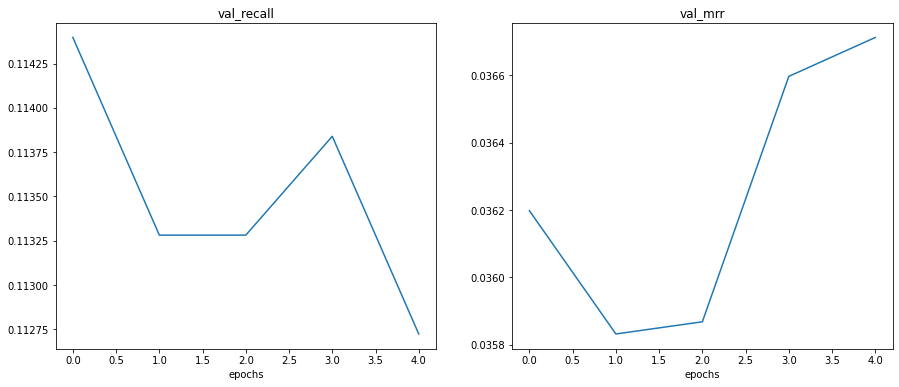

In [98]:
# 학습
train_model(model, args)

In [99]:
# 평가
test_model(model, args, test)

Evaluation:   6%|▌         | 2/33 [00:03<00:55,  1.81s/it]

	 - Recall@20: 0.117188
	 - MRR@20: 0.034935



##5.4: lr 변경 (0.001 -> 0.01)

In [100]:
args = Args(tr, val, test, batch_size=256, hsz=50, drop_rate=0.1, lr=0.01, epochs=5, k=20)

Evaluation:  15%|█▌        | 7/46 [00:12<01:09,  1.79s/it]


	 - Recall@20 epoch 1: 0.113839
	 - MRR@20    epoch 1: 0.036442



Evaluation:  15%|█▌        | 7/46 [00:12<01:09,  1.79s/it]


	 - Recall@20 epoch 2: 0.114955
	 - MRR@20    epoch 2: 0.037137



Evaluation:  15%|█▌        | 7/46 [00:12<01:09,  1.77s/it]


	 - Recall@20 epoch 3: 0.115513
	 - MRR@20    epoch 3: 0.036476



Evaluation:  15%|█▌        | 7/46 [00:12<01:09,  1.78s/it]


	 - Recall@20 epoch 4: 0.113839
	 - MRR@20    epoch 4: 0.036986



Evaluation:  15%|█▌        | 7/46 [00:12<01:09,  1.77s/it]


	 - Recall@20 epoch 5: 0.112165
	 - MRR@20    epoch 5: 0.036795



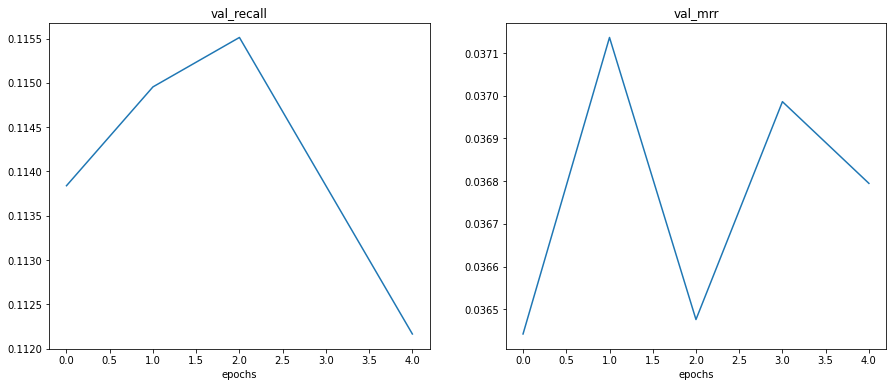

In [101]:
# 학습
train_model(model, args)

In [102]:
# 평가
test_model(model, args, test)

Evaluation:   6%|▌         | 2/33 [00:03<00:55,  1.79s/it]

	 - Recall@20: 0.115234
	 - MRR@20: 0.034033



#6: 결과

>* Recall기준으로, hsz=100, drop_rate=0.2일때 가장 높았다.
>* MRR기준으로, 기본 하이퍼파라미터 일때 가장 높았다.
>* 그러나 이상의 차이는 매우 작았으며, 보다 다양한 하이퍼파라미터 조정을 할 필요가 있는듯 하다.

#회고

>* Session-Based  Recommendation 모델에 대해 경험해 볼 수 있었다.
>*Session-Parallel Mini-Batch의 개념에 대해 배울 수 있었다.
>*다양한 하이퍼파라미터를 변경에 따른 Recall, MRR 변화를 확인해보았다.
>*data 전처리가 부족했었는데, 학습결과가 기대만큼 좋지못한거 같다.
>*사용자의 서비스 이용 형태에 대한 면밀한 분석에 따른 전처리가 부족했던거 같다.